In [1]:
# 第1块：导入所需库
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
# 第2块：定义 Dataset（不归一化，跳过第一列 lumi ID）
class HGCalDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file, index_col=False)
        self.data = df.iloc[:, 1:].values.astype(np.float32)  # 跳过 lumi ID
        # 注意：不再做除以255的归一化

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])


In [3]:
# 第3块：定义 AutoEncoder（104维 → 8维 → 104维）
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(104, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 104),
            nn.Identity()  # 不用 Sigmoid，因为不归一化
        )

    def forward(self, x):
        return self.dec(self.enc(x))


In [4]:
# 第4块：准备训练
csv_path = "hgcal_rdf_training_layer1.csv"  # ← 请替换成你的实际路径
dataset = HGCalDataset(csv_path)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [5]:
# 第5块：训练 AutoEncoder 并记录每轮 loss
epochs = 15
losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for batch in loader:
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")


Epoch 1/15 - Loss: 11298.010742
Epoch 2/15 - Loss: 11114.219866
Epoch 3/15 - Loss: 10624.580357
Epoch 4/15 - Loss: 9148.120396
Epoch 5/15 - Loss: 6380.444406
Epoch 6/15 - Loss: 3743.368129
Epoch 7/15 - Loss: 1850.453230
Epoch 8/15 - Loss: 732.663901
Epoch 9/15 - Loss: 310.561393
Epoch 10/15 - Loss: 159.843427
Epoch 11/15 - Loss: 90.591904
Epoch 12/15 - Loss: 54.750710
Epoch 13/15 - Loss: 38.120409
Epoch 14/15 - Loss: 36.690472
Epoch 15/15 - Loss: 34.193142


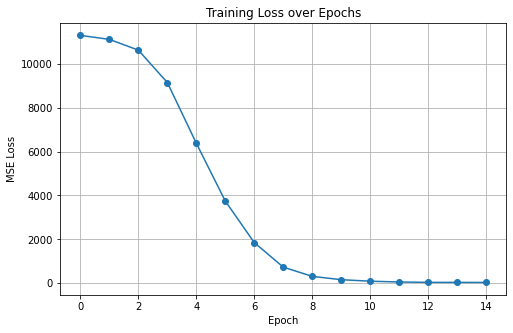

In [6]:
# 第6块：画出训练 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()
